## Import Libraries and Data

In [4]:
from helpers import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox
import statsmodels.api as sm

sns.set_theme()

In [5]:
df = pd.read_csv('prepared_data.csv',parse_dates=['Date'])

In [6]:
df_coffee = df.loc[df['Product']=='Coffee',['Date','Quantity']].reset_index(drop=True)
df_tea = df.loc[df['Product']=='Tea',['Date','Quantity']].reset_index(drop=True)

## Coffee

### EDA

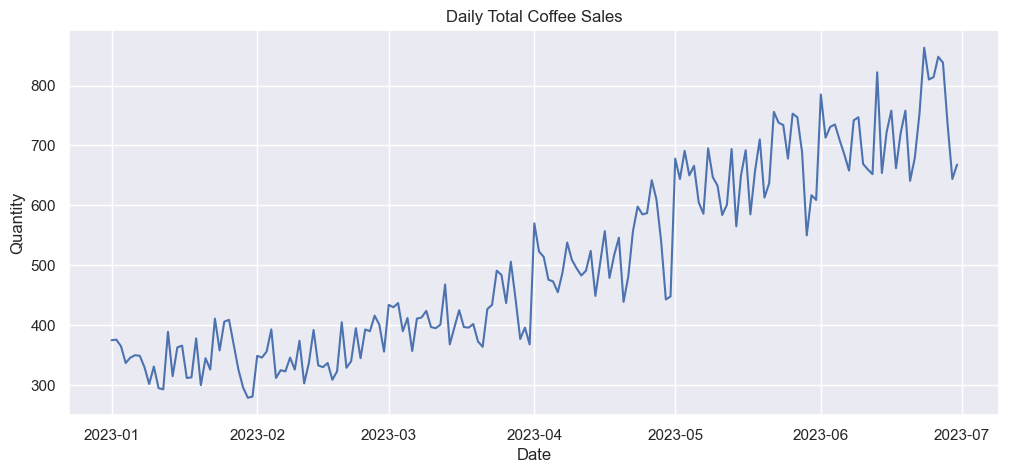

In [7]:
plt.figure(figsize= (12,5))
sns.lineplot(data=df_coffee, x='Date', y='Quantity').set(title = 'Daily Total Coffee Sales')
plt.show()

In [8]:
df_coffee

,Date,Quantity
0,2023-01-01,375
1,2023-01-02,376
2,2023-01-03,365
3,2023-01-04,337
4,2023-01-05,346
...,...,...
176,2023-06-26,848
177,2023-06-27,838
178,2023-06-28,734
179,2023-06-29,644


In [9]:
trend_stationary(df_coffee,'Quantity')

ADF statistic is 0.89
the p-value of this series is 0.99 and is therefore not stationary.
We cannot reject the null hypothesis of a unit root


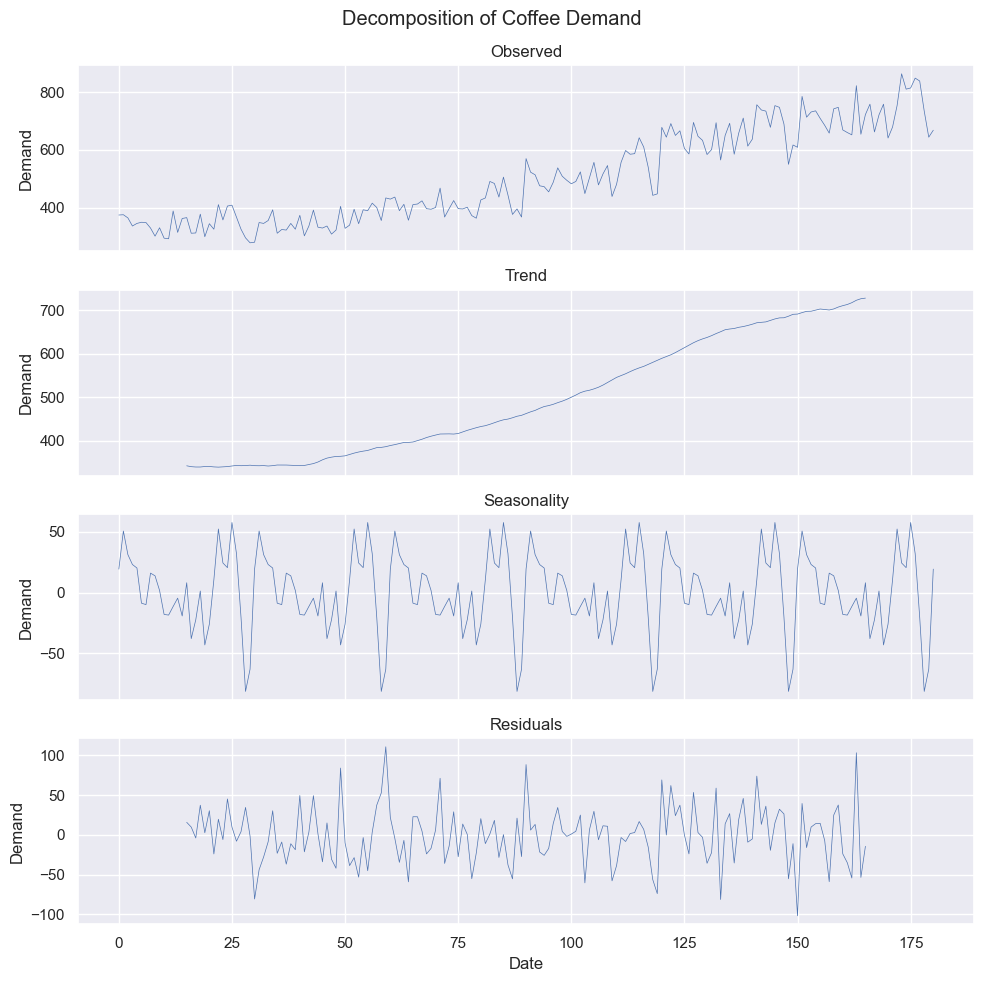

In [10]:
time_series_decomposition(df_coffee['Quantity'], plot_title= 'Decomposition of Coffee Demand', plot_y= "Demand")

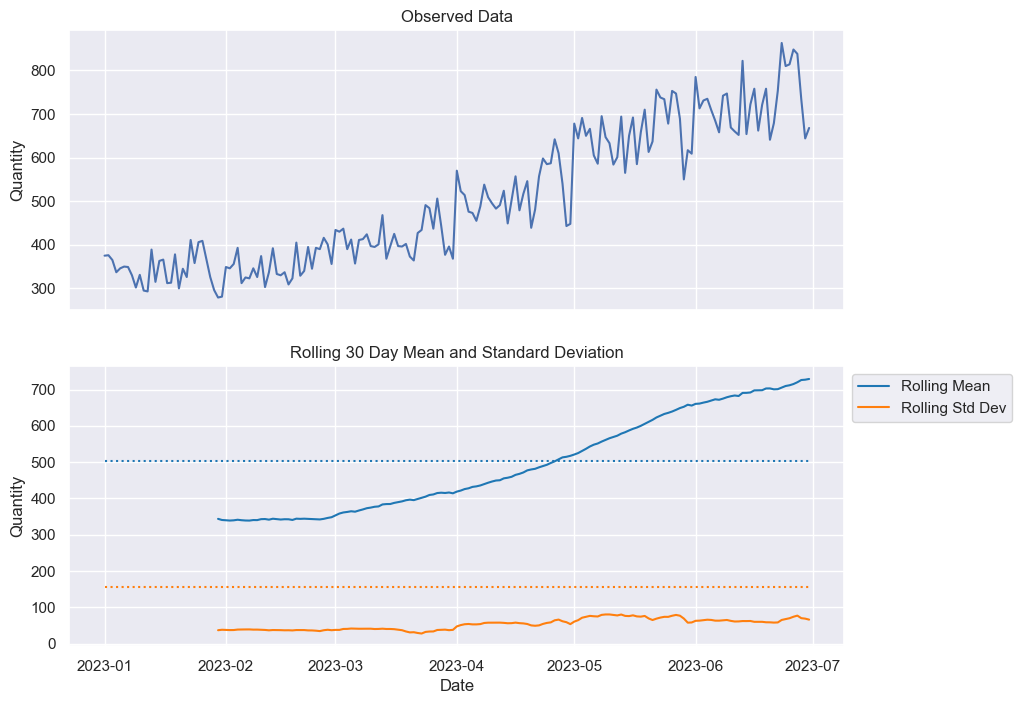

In [11]:
df_coffee_stat = df_coffee.copy()

df_coffee_stat['rolling mean'] = df_coffee['Quantity'].rolling(window=30).mean()
df_coffee_stat['rolling std'] = df_coffee['Quantity'].rolling(window=30).std()
df_coffee_stat['overall_mean'] = df_coffee['Quantity'].mean()
df_coffee_stat['overall_std'] = df_coffee['Quantity'].std()

tb_blue = '#1f77b4'
tb_orange = '#ff7f0e'

fig, axes= plt.subplots(2,1, figsize=(10, 8),sharex=True)

sns.lineplot(data=df_coffee_stat, x='Date',y='Quantity',errorbar=None, ax=axes[0])
sns.lineplot(df_coffee_stat,x='Date', y='rolling mean',errorbar=None,ax=axes[1],color=tb_blue)
sns.lineplot(df_coffee_stat,x='Date', y='rolling std',errorbar=None,ax=axes[1],color=tb_orange)
sns.lineplot(df_coffee_stat,x='Date',y='overall_mean',errorbar=None,ax=axes[1],linestyle = ':',color=tb_blue)
sns.lineplot(df_coffee_stat,x='Date',y='overall_std',errorbar=None,ax=axes[1],linestyle = ':',color= tb_orange)
             
axes[0].set(title = 'Observed Data',
       xlabel = 'Date',
       ylabel='Quantity')
#axes[0].set_ylim(-1.5,1.5)

axes[1].set(title = 'Rolling 30 Day Mean and Standard Deviation',
       xlabel = 'Date',
       ylabel='Quantity')
axes[1].legend(loc="upper left", labels=[ "Rolling Mean", "Rolling Std Dev"])
#axes[1].set_ylim(-1.5,1.5)

sns.move_legend(axes[1], "upper left", bbox_to_anchor=(1, 1))


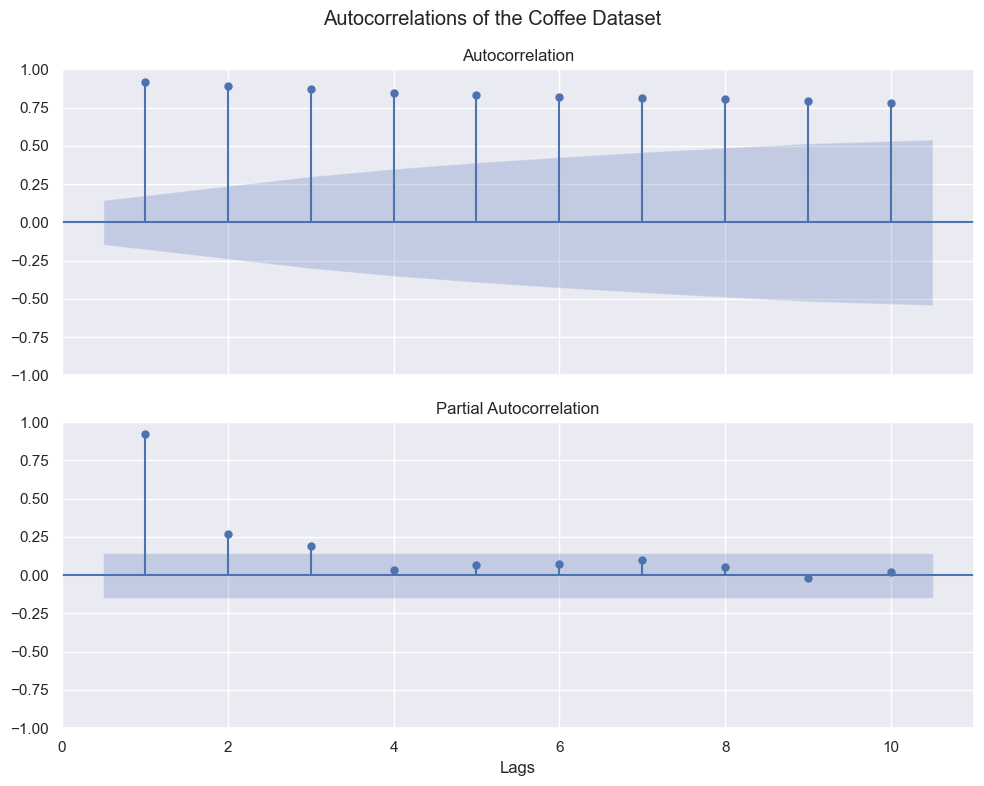

In [12]:
acf_pacf(df_coffee['Quantity'],"Autocorrelations of the Coffee Dataset")

### Make Stationary

In [13]:
scaler = StandardScaler()

In [14]:
df_coffee_stationary = df_coffee.copy()

#apply box cox to only the training set
df_coffee_stationary = df_coffee_stationary[df_coffee_stationary['Date'] <= '2023-05-31']

df_coffee_stationary['Quantity_log'] = np.log(df_coffee_stationary['Quantity'])
df_coffee_stationary['Quantity_BC'], lam = boxcox(df_coffee_stationary['Quantity'])

df_coffee_stationary['Scaled_Quantity_log'] = scaler.fit_transform(df_coffee_stationary[['Quantity_log']])
df_coffee_stationary['Scaled_Quantity_BC'] = scaler.fit_transform(df_coffee_stationary[['Quantity_BC']])

df_coffee_stationary['Difference'] = df_coffee_stationary['Quantity'].diff()

df_coffee_stationary['Difference_log'] = df_coffee_stationary['Quantity_log'].diff()
df_coffee_stationary['Difference_BC'] = df_coffee_stationary['Quantity_BC'].diff()

df_coffee_stationary['Difference_Scaled_log'] = df_coffee_stationary['Scaled_Quantity_log'].diff()
df_coffee_stationary['Difference_Scaled_BC'] = df_coffee_stationary['Scaled_Quantity_BC'].diff()

print(f'Box-Cox Transformation \u03BB = {lam:.2f}')

df_coffee_stationary

Box-Cox Transformation λ = -0.78


,Date,Quantity,Quantity_log,Quantity_BC,Scaled_Quantity_log,Scaled_Quantity_BC,Difference,Difference_log,Difference_BC,Difference_Scaled_log,Difference_Scaled_BC
0,2023-01-01,375,5.926926,1.267371,-0.622177,-0.572682,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,376,5.929589,1.267397,-0.612116,-0.561042,1.0,0.002663,0.000026,0.010061,0.011640
2,2023-01-03,365,5.899897,1.267105,-0.724285,-0.692201,-11.0,-0.029692,-0.000292,-0.112169,-0.131159
3,2023-01-04,337,5.820083,1.266285,-1.025805,-1.060231,-28.0,-0.079814,-0.000820,-0.301520,-0.368030
4,2023-01-05,346,5.846439,1.266562,-0.926239,-0.936155,9.0,0.026356,0.000276,0.099566,0.124076
...,...,...,...,...,...,...,...,...,...,...,...
146,2023-05-27,747,6.616065,1.272564,1.981229,1.758813,-6.0,-0.008000,-0.000045,-0.030222,-0.020366
147,2023-05-28,689,6.535241,1.272090,1.675895,1.545757,-58.0,-0.080824,-0.000475,-0.305334,-0.213056
148,2023-05-29,550,6.309918,1.270597,0.824678,0.875576,-139.0,-0.225323,-0.001493,-0.851217,-0.670181
149,2023-05-30,617,6.424869,1.271391,1.258935,1.232200,67.0,0.114951,0.000794,0.434257,0.356623


#### Rolling Means and Standard Deviations

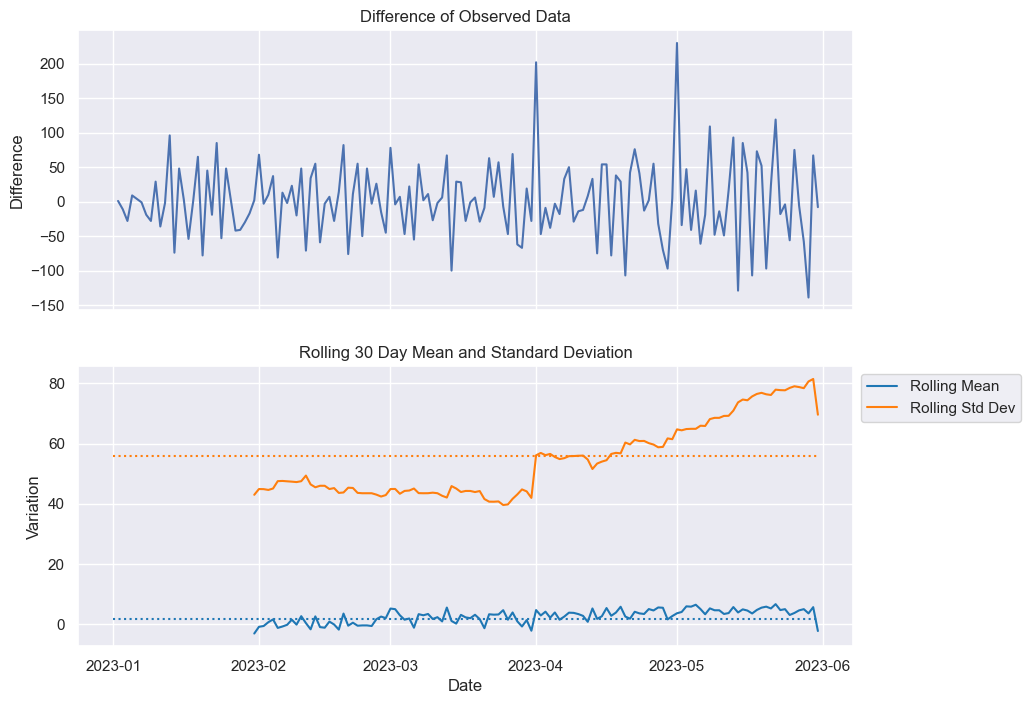

In [39]:
mean_std_view(df_coffee_stationary, 'Difference', title = 'Difference of Observed Data')

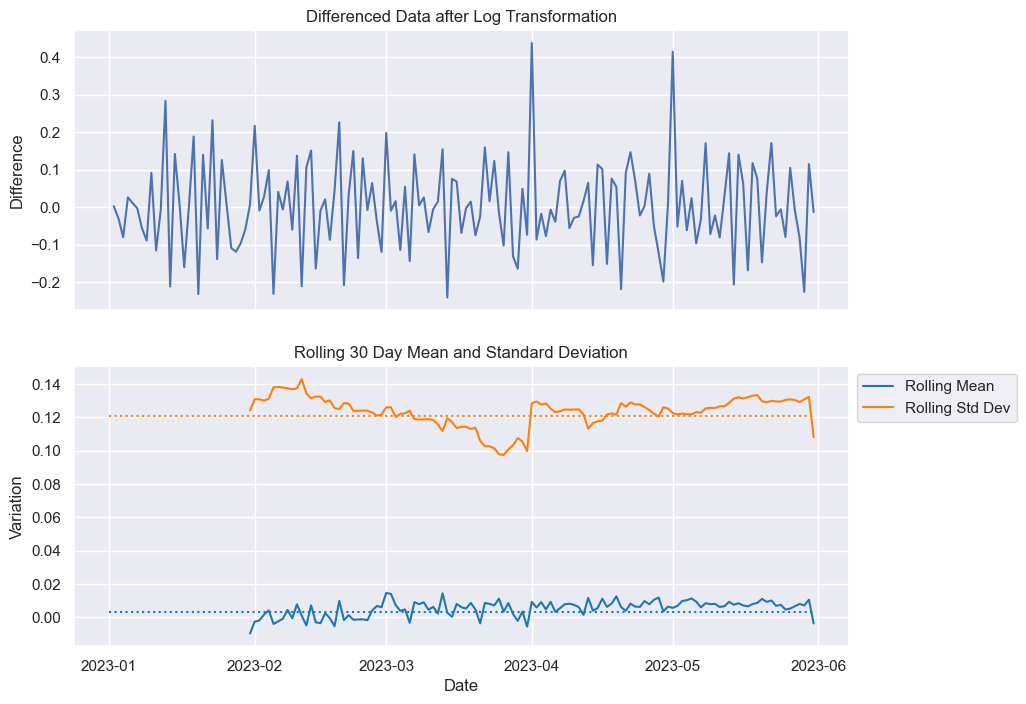

In [38]:
mean_std_view(df_coffee_stationary,'Difference_log',title = 'Differenced Data after Log Transformation')

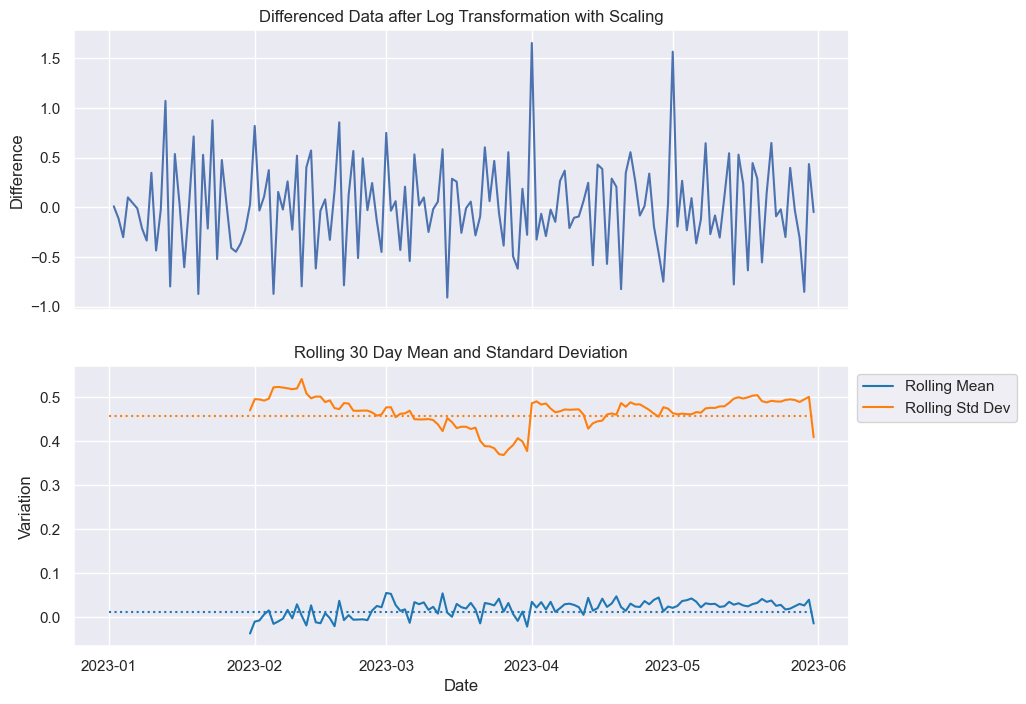

In [50]:
mean_std_view(df_coffee_stationary,'Difference_Scaled_log',title = 'Differenced Data after Log Transformation with Scaling')

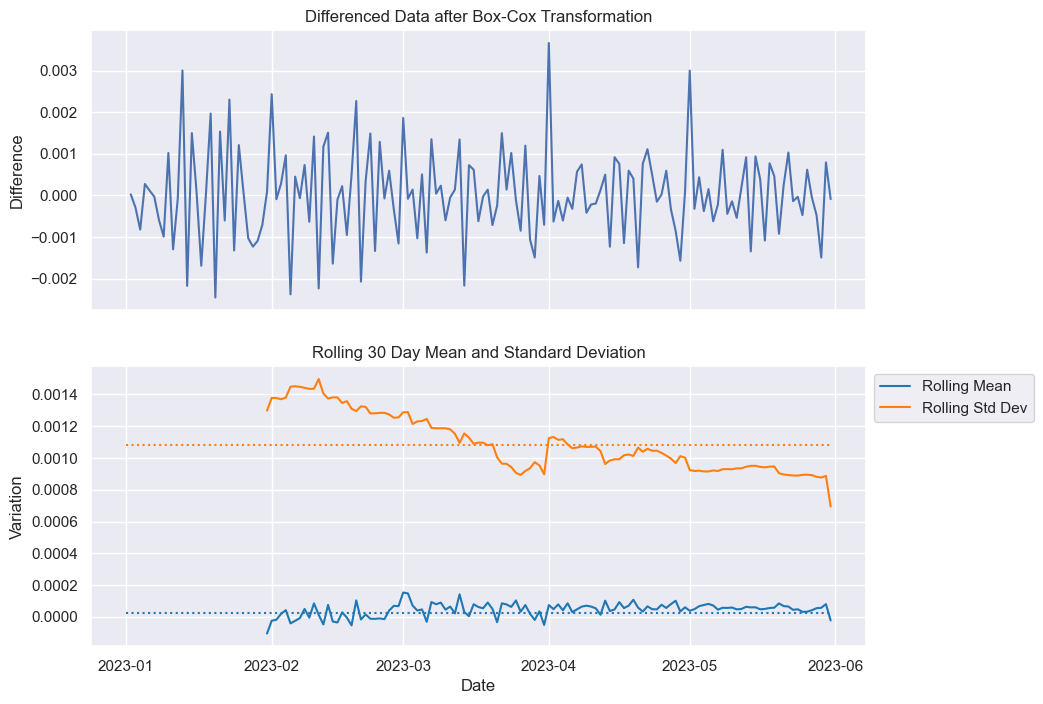

In [17]:
mean_std_view(df_coffee_stationary,'Difference_BC',title='Differenced Data after Box-Cox Transformation')

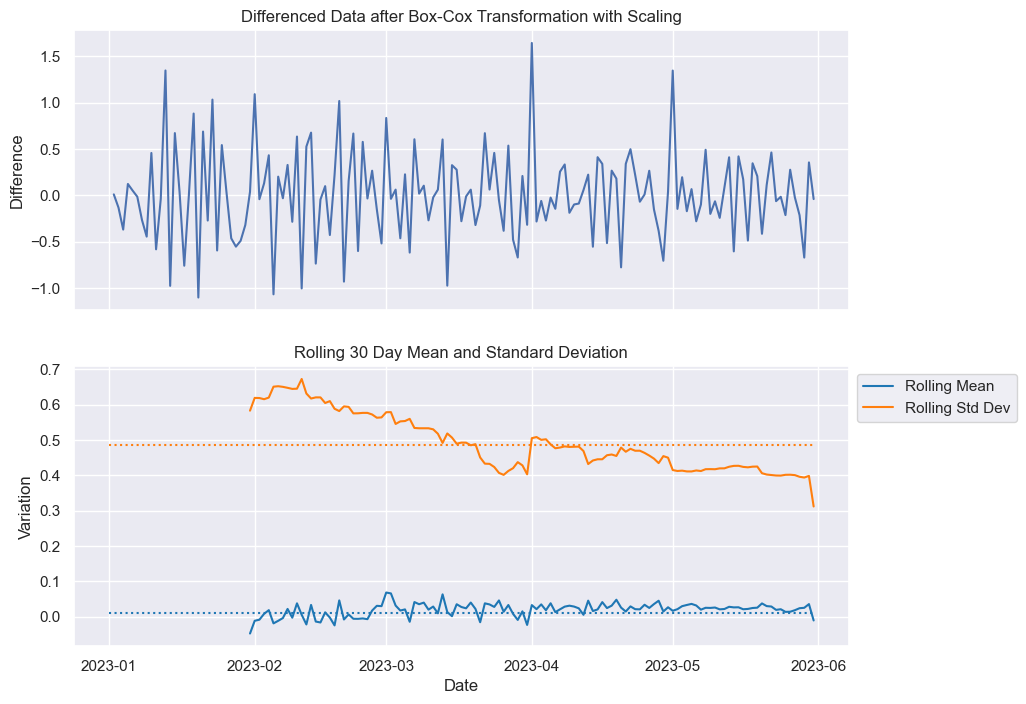

In [49]:
mean_std_view(df_coffee_stationary,'Difference_Scaled_BC',title='Differenced Data after Box-Cox Transformation with Scaling')

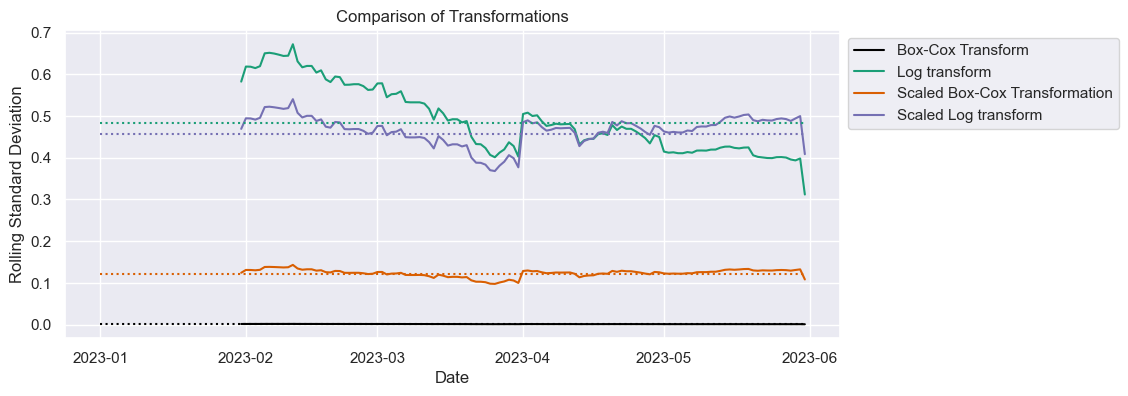

In [54]:
df_coffee_std = df_coffee_stationary.copy()

plt.figure(figsize = (10,4))

df_coffee_std['rolling_std_bc'] = df_coffee_stationary['Difference_BC'].rolling(window=30).std()
df_coffee_std['overall_std_bc'] = df_coffee_stationary['Difference_BC'].std()

df_coffee_std['rolling_std_log'] = df_coffee_stationary['Difference_log'].rolling(window=30).std()
df_coffee_std['overall_std_log'] = df_coffee_stationary['Difference_log'].std()

df_coffee_std['rolling_std_bc_scaled'] = df_coffee_stationary['Difference_Scaled_BC'].rolling(window=30).std()
df_coffee_std['overall_std_bc_scaled'] = df_coffee_stationary['Difference_Scaled_BC'].std()

df_coffee_std['rolling_std_log_scaled'] = df_coffee_stationary['Difference_Scaled_log'].rolling(window=30).std()
df_coffee_std['overall_std_log_scaled'] = df_coffee_stationary['Difference_Scaled_log'].std()

tb_blue = '#000000'
tb_orange ="#1B9E77"
tb_pink =  '#D95F02'
tb_green = "#7570B3"

ax = sns.lineplot(df_coffee_std,x='Date', y='rolling_std_bc',errorbar=None,color=tb_blue)
ax = sns.lineplot(df_coffee_std,x='Date', y='rolling_std_bc_scaled',errorbar=None,color=tb_orange)
ax = sns.lineplot(df_coffee_std,x='Date', y='rolling_std_log',errorbar=None,color=tb_pink)
ax = sns.lineplot(df_coffee_std,x='Date', y='rolling_std_log_scaled',errorbar=None,color=tb_green)


ax = sns.lineplot(df_coffee_std,x='Date',y='overall_std_bc',errorbar=None,linestyle = ':',color= tb_blue)
ax = sns.lineplot(df_coffee_std,x='Date',y='overall_std_bc_scaled',errorbar=None,linestyle = ':',color=tb_orange)
ax = sns.lineplot(df_coffee_std,x='Date',y='overall_std_log',errorbar=None,linestyle = ':',color= tb_pink)
ax = sns.lineplot(df_coffee_std,x='Date',y='overall_std_log_scaled',errorbar=None,linestyle = ':',color=tb_green)

ax.set(title = 'Comparison of Transformations',
       xlabel = 'Date',
      ylabel='Rolling Standard Deviation')
ax.legend(loc="upper left", labels=["Box-Cox Transform", "Log transform","Scaled Box-Cox Transformation","Scaled Log transform"])

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

#### ADF Test

In [60]:
sets = ['Difference','Difference_log','Difference_BC','Difference_Scaled_BC','Difference_Scaled_log']

for data in sets:
    print(f'Augmented Dickey Fuller Test for the data in {data}:')
    trend_stationary(df_coffee_stationary.dropna(),data)
    print('\n')

Augmented Dickey Fuller Test for the data in Difference:
ADF statistic is -7.80
the p-value of this series is 0.00 and is therefore stationary.
We can reject at 99% confidence


Augmented Dickey Fuller Test for the data in Difference_log:
ADF statistic is -7.57
the p-value of this series is 0.00 and is therefore stationary.
We can reject at 99% confidence


Augmented Dickey Fuller Test for the data in Difference_BC:
ADF statistic is -7.77
the p-value of this series is 0.00 and is therefore stationary.
We can reject at 99% confidence


Augmented Dickey Fuller Test for the data in Difference_Scaled_BC:
ADF statistic is -7.77
the p-value of this series is 0.00 and is therefore stationary.
We can reject at 99% confidence


Augmented Dickey Fuller Test for the data in Difference_Scaled_log:
ADF statistic is -7.57
the p-value of this series is 0.00 and is therefore stationary.
We can reject at 99% confidence




The ACF and PACF plots indicate an MA(1) model or ARIMA(0,1,1) since we took a single difference. An AR(1) model may not be appropriate

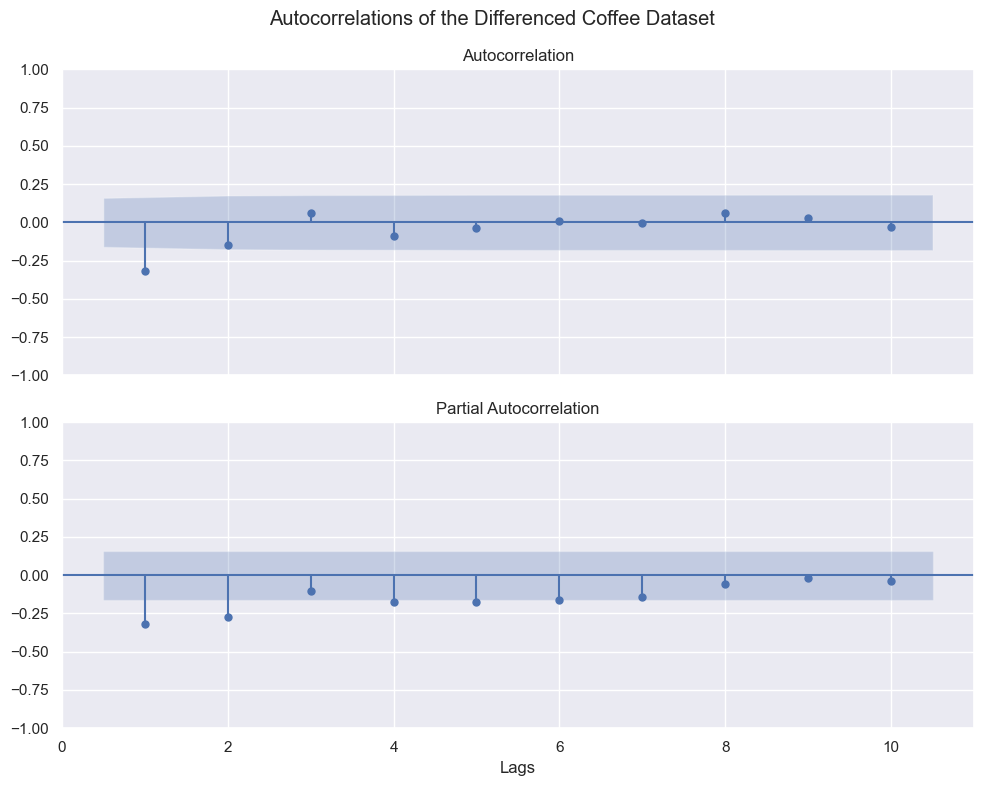

In [23]:
acf_pacf(df_coffee_stationary['Difference'],"Autocorrelations of the Differenced Coffee Dataset")

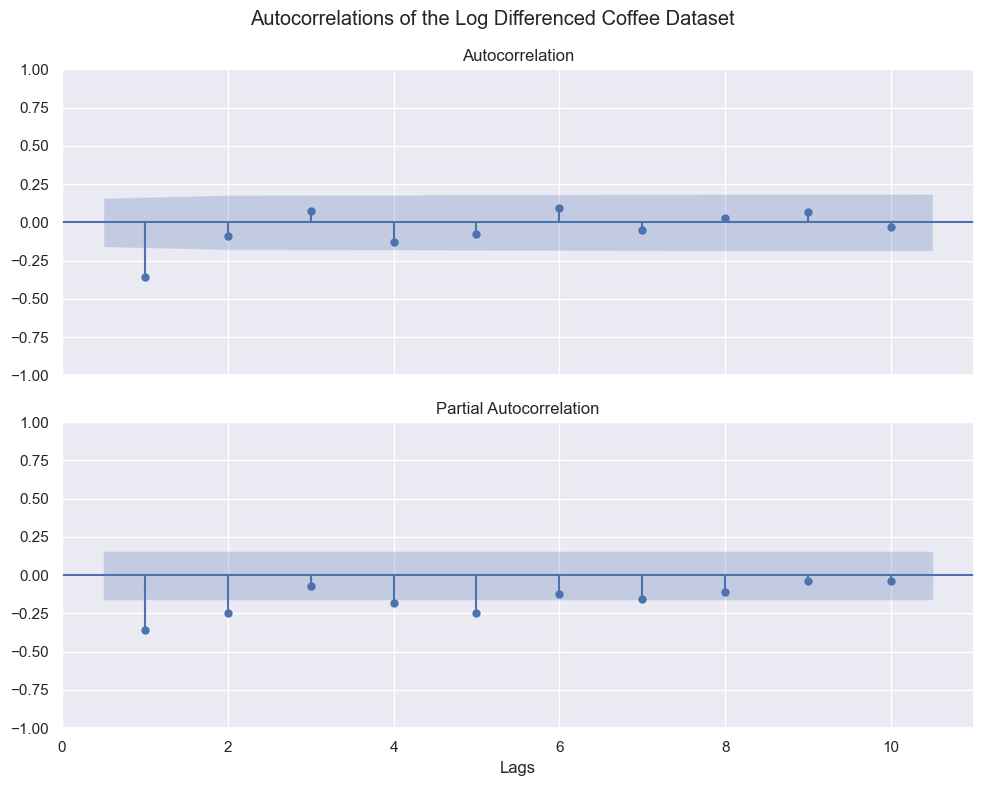

In [24]:
acf_pacf(df_coffee_stationary['Difference_log'],"Autocorrelations of the Log Differenced Coffee Dataset")

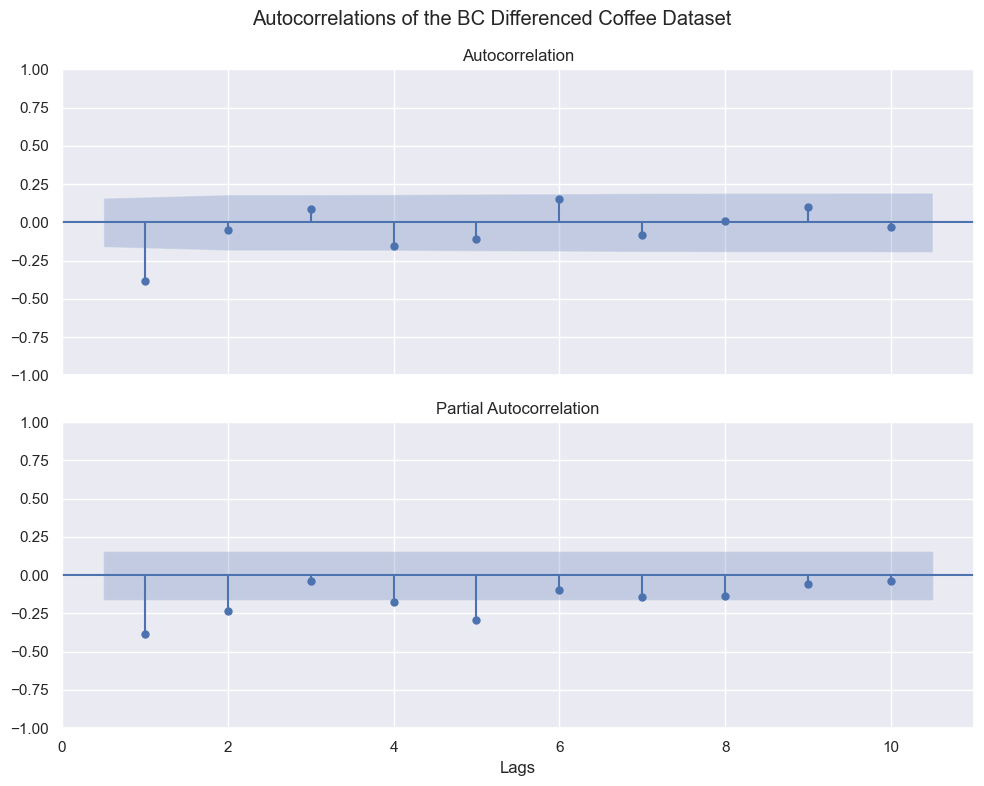

In [25]:
acf_pacf(df_coffee_stationary['Difference_BC'],"Autocorrelations of the BC Differenced Coffee Dataset")

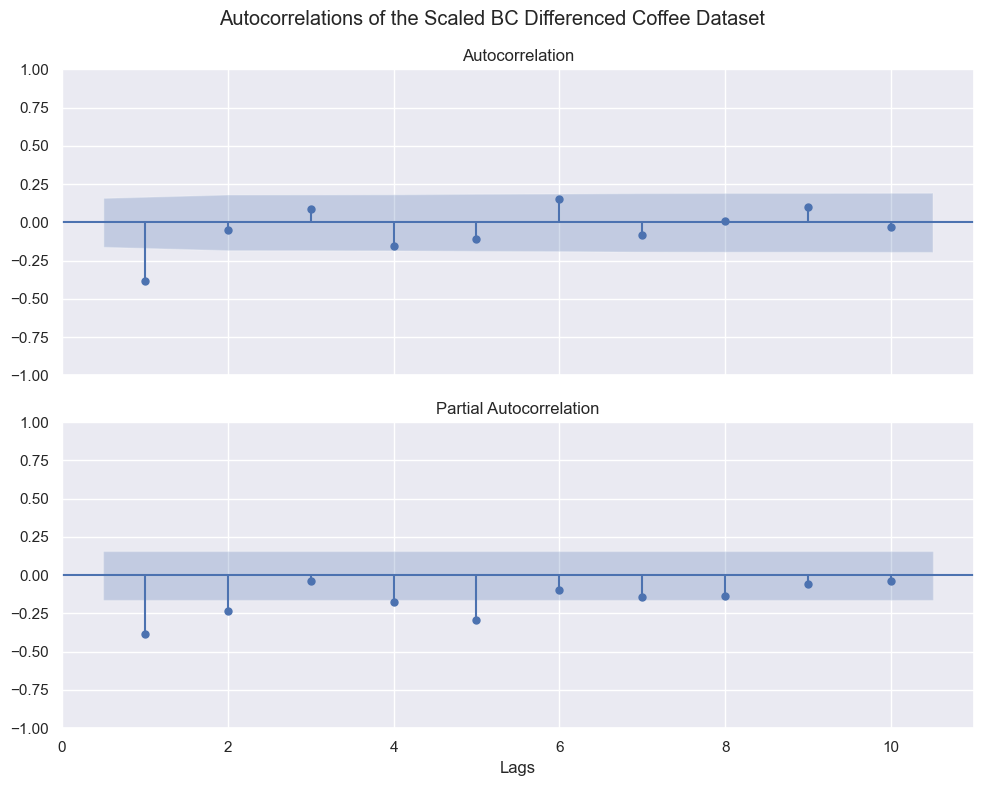

In [63]:
acf_pacf(df_coffee_stationary['Difference_Scaled_BC'],"Autocorrelations of the Scaled BC Differenced Coffee Dataset")

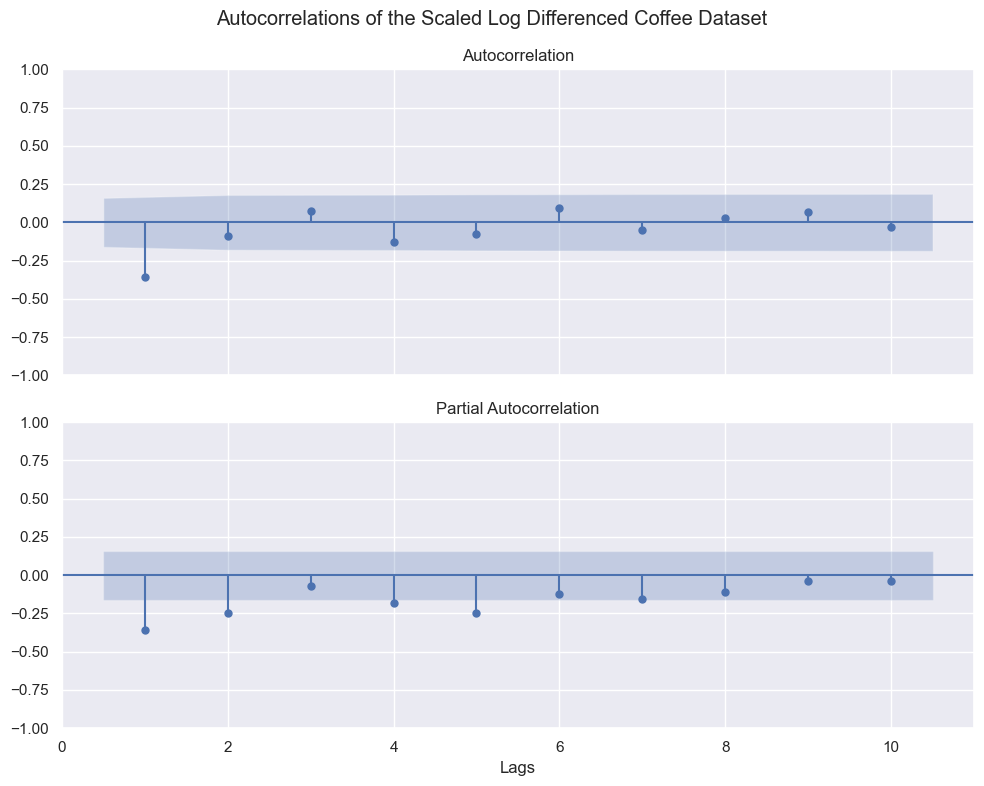

In [64]:
acf_pacf(df_coffee_stationary['Difference_Scaled_log'],"Autocorrelations of the Scaled Log Differenced Coffee Dataset")

### Model Development

In [65]:
df_lagged = df_coffee_stationary.copy()
df_lagged = df_lagged[['Date','Quantity','Difference']]
time_lag(df_lagged, lagged_qty= 'Difference', steps=10)
df_lagged.head(10)

,Date,Quantity,Difference,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10
0,2023-01-01,375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-02,376,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-03,365,-11.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-04,337,-28.0,-11.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-05,346,9.0,-28.0,-11.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2023-01-06,350,4.0,9.0,-28.0,-11.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
6,2023-01-07,349,-1.0,4.0,9.0,-28.0,-11.0,1.0,NaN,NaN,NaN,NaN,NaN
7,2023-01-08,330,-19.0,-1.0,4.0,9.0,-28.0,-11.0,1.0,NaN,NaN,NaN,NaN
8,2023-01-09,302,-28.0,-19.0,-1.0,4.0,9.0,-28.0,-11.0,1.0,NaN,NaN,NaN
9,2023-01-10,331,29.0,-28.0,-19.0,-1.0,4.0,9.0,-28.0,-11.0,1.0,NaN,NaN


In [27]:
model_diff, summary_diff = model_test_no_space(df_coffee_stationary,target='Difference',steps=30)
summary_diff

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Difference   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     3.632
Date:                Mon, 10 Nov 2025   Prob (F-statistic):           1.28e-06
Time:                        15:02:27   Log-Likelihood:                -610.94
No. Observations:                 120   AIC:                             1284.
Df Residuals:                      89   BIC:                             1370.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.1770      7.315      2.348      0.021       2.643      31.711
t-1           -0.5946      0.106     -5.631      0.000      -0.804      -0.385
t-2           -0.5972      0.115     -5.175      0.000      -0.826      -0.368
t-3           -0.4731      0.128     -3.700      0.000      -0.727      -0.219
t-4           -0.5008      0.136     -3.683      0.000      -0.771      -0.231
t-5           -0.5053      0.144     -3.504      0.001      -0.792      -0.219
t-6           -0.3930      0.153     -2.573      0.012      -0.696      -0.089
t-7           -0.2769      0.158     -1.753      0.083      -0.591       0.037
t-8           -0.2354      0.160     -1.473      0.144      -0.553       0.082
t-9           -0.1638      0.162     -1.013      0.314      -0.485       0.157
t-10          -0.1950      0.164     -1.186      0.239      -0.522       0.132
t-11          -0.1203      0.167     -0.720      0.473      -0.452       0.212
t-12           0.0638      0.168      0.381      0.704      -0.269       0.397
t-13          -0.2054      0.169     -1.215      0.228      -0.541       0.131
t-14           0.0106      0.172      0.061      0.951      -0.332       0.353
t-15           0.0290      0.172      0.168      0.867      -0.313       0.371
t-16           0.0318      0.172      0.185      0.854      -0.311       0.374
t-17           0.1175      0.172      0.682      0.497      -0.225       0.460
t-18           0.0622      0.173      0.360      0.719      -0.281       0.405
t-19           0.0615      0.171      0.360      0.720      -0.278       0.401
t-20           0.1079      0.171      0.630      0.530      -0.232       0.448
t-21           0.0375      0.172      0.218      0.828      -0.304       0.379
t-22           0.0706      0.173      0.408      0.684      -0.273       0.414
t-23          -0.0371      0.172     -0.216      0.829      -0.378       0.304
t-24          -0.2469      0.169     -1.465      0.146      -0.582       0.088
t-25           0.0010      0.166      0.006      0.995      -0.329       0.331
t-26          -0.2307      0.155     -1.488      0.140      -0.539       0.077
t-27          -0.2438      0.146     -1.670      0.098      -0.534       0.046
t-28          -0.4801      0.136     -3.519      0.001      -0.751      -0.209
t-29          -0.4423      0.129     -3.416      0.001      -0.700      -0.185
t-30          -0.0024      0.118     -0.020      0.984      -0.236       0.232
==============================================================================
Omnibus:                       12.458   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.696
Skew:                           0.675   Prob(JB):                      0.00106
Kurtosis:                       3.956   Cond. No.                         146.
==

In [28]:
model_log, summary_log = model_test_no_space(df_coffee_stationary,target='Difference_log',steps=30)
summary_log

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Difference_log   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     3.400
Date:                Mon, 10 Nov 2025   Prob (F-statistic):           4.21e-06
Time:                        15:02:27   Log-Likelihood:                 130.26
No. Observations:                 120   AIC:                            -198.5
Df Residuals:                      89   BIC:                            -112.1
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0468      0.016      2.921      0.004       0.015       0.079
t-1           -0.6609      0.104     -6.365      0.000      -0.867      -0.455
t-2           -0.6514      0.115     -5.656      0.000      -0.880      -0.423
t-3           -0.5575      0.127     -4.394      0.000      -0.810      -0.305
t-4           -0.5682      0.135     -4.221      0.000      -0.836      -0.301
t-5           -0.5525      0.142     -3.887      0.000      -0.835      -0.270
t-6           -0.4237      0.152     -2.793      0.006      -0.725      -0.122
t-7           -0.3198      0.157     -2.039      0.044      -0.631      -0.008
t-8           -0.2915      0.159     -1.836      0.070      -0.607       0.024
t-9           -0.1744      0.162     -1.077      0.284      -0.496       0.147
t-10          -0.1980      0.163     -1.218      0.226      -0.521       0.125
t-11          -0.1266      0.164     -0.772      0.442      -0.452       0.199
t-12           0.0204      0.164      0.124      0.901      -0.305       0.346
t-13          -0.2414      0.164     -1.476      0.144      -0.566       0.084
t-14          -0.0874      0.166     -0.526      0.600      -0.417       0.242
t-15          -0.0514      0.166     -0.310      0.757      -0.380       0.278
t-16          -0.0404      0.165     -0.244      0.808      -0.369       0.288
t-17          -0.0130      0.165     -0.079      0.937      -0.342       0.316
t-18          -0.0458      0.165     -0.278      0.782      -0.373       0.281
t-19          -0.0807      0.165     -0.490      0.625      -0.408       0.246
t-20          -0.0636      0.164     -0.387      0.700      -0.390       0.263
t-21          -0.1447      0.163     -0.888      0.377      -0.468       0.179
t-22          -0.0656      0.163     -0.402      0.689      -0.390       0.259
t-23          -0.1717      0.159     -1.080      0.283      -0.487       0.144
t-24          -0.3075      0.155     -1.988      0.050      -0.615      -0.000
t-25          -0.1049      0.151     -0.697      0.488      -0.404       0.194
t-26          -0.2769      0.138     -1.999      0.049      -0.552      -0.002
t-27          -0.2815      0.130     -2.170      0.033      -0.539      -0.024
t-28          -0.4091      0.120     -3.399      0.001      -0.648      -0.170
t-29          -0.3516      0.112     -3.141      0.002      -0.574      -0.129
t-30          -0.0993      0.098     -1.014      0.313      -0.294       0.095
==============================================================================
Omnibus:                        6.230   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                5.735
Skew:                           0.465   Prob(JB):                       0.0568
Kurtosis:                       3.531   Cond. No.                         56.5
==

In [29]:
model_bc, summary_bc = model_test_no_space(df_coffee_stationary,target='Difference_BC',steps=30)
summary_bc

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Difference_BC   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     3.644
Date:                Mon, 10 Nov 2025   Prob (F-statistic):           1.21e-06
Time:                        15:02:28   Log-Likelihood:                 704.75
No. Observations:                 120   AIC:                            -1347.
Df Residuals:                      89   BIC:                            -1261.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      3.256      0.002       0.000       0.001
t-1           -0.7023      0.102     -6.895      0.000      -0.905      -0.500
t-2           -0.6679      0.114     -5.883      0.000      -0.893      -0.442
t-3           -0.5891      0.123     -4.794      0.000      -0.833      -0.345
t-4           -0.5965      0.129     -4.616      0.000      -0.853      -0.340
t-5           -0.5664      0.136     -4.165      0.000      -0.837      -0.296
t-6           -0.4172      0.146     -2.861      0.005      -0.707      -0.127
t-7           -0.3240      0.150     -2.158      0.034      -0.622      -0.026
t-8           -0.3116      0.152     -2.056      0.043      -0.613      -0.010
t-9           -0.1790      0.155     -1.153      0.252      -0.488       0.130
t-10          -0.2022      0.155     -1.302      0.196      -0.511       0.106
t-11          -0.1268      0.157     -0.809      0.421      -0.438       0.185
t-12          -0.0102      0.156     -0.065      0.948      -0.321       0.301
t-13          -0.2655      0.156     -1.705      0.092      -0.575       0.044
t-14          -0.1477      0.158     -0.935      0.352      -0.462       0.166
t-15          -0.1174      0.157     -0.745      0.458      -0.430       0.196
t-16          -0.0845      0.157     -0.539      0.591      -0.396       0.227
t-17          -0.0784      0.157     -0.500      0.618      -0.389       0.233
t-18          -0.0957      0.155     -0.616      0.539      -0.404       0.213
t-19          -0.1474      0.156     -0.947      0.346      -0.457       0.162
t-20          -0.1444      0.155     -0.931      0.354      -0.453       0.164
t-21          -0.2129      0.153     -1.391      0.168      -0.517       0.091
t-22          -0.1255      0.153     -0.821      0.414      -0.429       0.178
t-23          -0.2288      0.147     -1.554      0.124      -0.521       0.064
t-24          -0.3233      0.143     -2.261      0.026      -0.607      -0.039
t-25          -0.1512      0.138     -1.093      0.277      -0.426       0.124
t-26          -0.2872      0.126     -2.275      0.025      -0.538      -0.036
t-27          -0.2933      0.118     -2.493      0.015      -0.527      -0.060
t-28          -0.3562      0.109     -3.271      0.002      -0.573      -0.140
t-29          -0.2914      0.101     -2.897      0.005      -0.491      -0.091
t-30          -0.1416      0.086     -1.647      0.103      -0.312       0.029
==============================================================================
Omnibus:                        4.559   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                4.027
Skew:                           0.359   Prob(JB):                        0.133
Kurtosis:                       3.537   Cond. No.                     6.71e+03
==

In [30]:
df_model_bc = df_coffee_stationary.copy()
df_model_bc = df_model_bc[['Date','Quantity','Quantity_BC','Difference_BC']]

time_lag(df_model_bc,'Difference_BC',steps=31)

df_model_bc = df_model_bc.dropna().reset_index(drop=True)

target = df_model_bc['Difference_BC']
features = df_model_bc.filter(like='t-',axis=1)

features = sm.add_constant(features)

features

model_bc = sm.OLS(target,features).fit()

model_bc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Difference_BC   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     3.545
Date:                Mon, 10 Nov 2025   Prob (F-statistic):           1.85e-06
Time:                        15:02:28   Log-Likelihood:                 702.10
No. Observations:                 119   AIC:                            -1340.
Df Residuals:                      87   BIC:                            -1251.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.574      0.012    8.11e-05       0.001
t-1           -0.6659      0.104     -6.390      0.000      -0.873      -0.459
t-2           -0.5959      0.124     -4.794      0.000      -0.843      -0.349
t-3           -0.5146      0.133     -3.863      0.000      -0.779      -0.250
t-4           -0.5492      0.137     -4.016      0.000      -0.821      -0.277
t-5           -0.5220      0.142     -3.671      0.000      -0.805      -0.239
t-6           -0.4108      0.146     -2.812      0.006      -0.701      -0.120
t-7           -0.2791      0.150     -1.858      0.067      -0.578       0.019
t-8           -0.2920      0.152     -1.924      0.058      -0.594       0.010
t-9           -0.1811      0.152     -1.190      0.237      -0.484       0.121
t-10          -0.1760      0.153     -1.148      0.254      -0.481       0.129
t-11          -0.1149      0.154     -0.747      0.457      -0.420       0.191
t-12           0.0142      0.154      0.092      0.927      -0.293       0.321
t-13          -0.2398      0.153     -1.564      0.121      -0.545       0.065
t-14          -0.1247      0.155     -0.803      0.424      -0.433       0.184
t-15          -0.0889      0.156     -0.571      0.570      -0.399       0.221
t-16          -0.0474      0.155     -0.306      0.760      -0.355       0.260
t-17          -0.0492      0.154     -0.319      0.750      -0.355       0.257
t-18          -0.0539      0.154     -0.350      0.727      -0.360       0.252
t-19          -0.1390      0.153     -0.911      0.365      -0.442       0.164
t-20          -0.1109      0.154     -0.722      0.472      -0.416       0.195
t-21          -0.1728      0.154     -1.125      0.264      -0.478       0.132
t-22          -0.0787      0.152     -0.516      0.607      -0.382       0.224
t-23          -0.1564      0.151     -1.038      0.302      -0.456       0.143
t-24          -0.2446      0.146     -1.672      0.098      -0.535       0.046
t-25          -0.0643      0.144     -0.445      0.658      -0.351       0.223
t-26          -0.1599      0.137     -1.171      0.245      -0.431       0.112
t-27          -0.1727      0.127     -1.357      0.178      -0.426       0.080
t-28          -0.2532      0.119     -2.122      0.037      -0.490      -0.016
t-29          -0.1765      0.113     -1.562      0.122      -0.401       0.048
t-30          -0.0041      0.103     -0.039      0.969      -0.209       0.201
t-31           0.2058      0.087      2.369      0.020       0.033       0.379
==============================================================================
Omnibus:                        4.976   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.083   Jarque-Bera (JB):                4.625
Skew:                           0.351   Prob(JB):                       0.0990
Ku

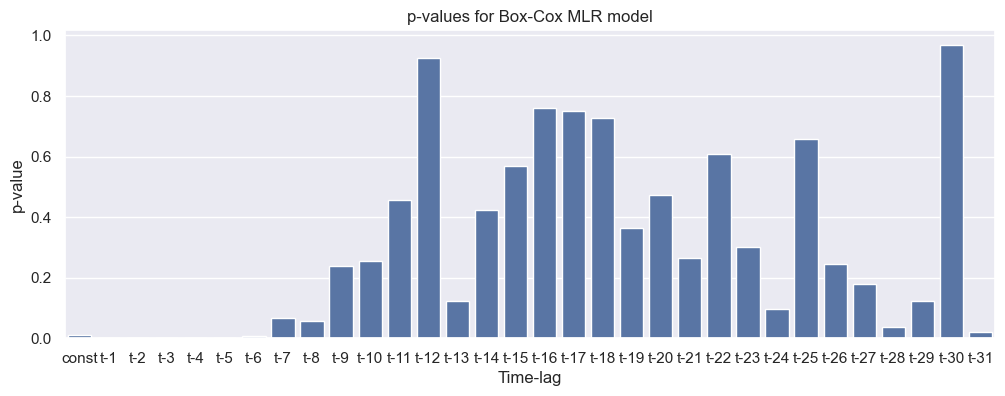

In [31]:
plt.figure(figsize=(12,4))
ax = sns.barplot(x = model_bc.pvalues.index, y=model_bc.pvalues)
ax.set(title = "p-values for Box-Cox MLR model", xlabel= "Time-lag", ylabel='p-value')
plt.show()

## MLR Model Selection and Test

In [43]:
split_date = '2023-05-31'

mlr_bc_model_train = df_coffee[df_coffee['Date']<= split_date].copy()
mlr_bc_model_test = df_coffee[df_coffee['Date'] > split_date].copy()

In [33]:
scaler = StandardScaler()

In [45]:
mlr_bc_model_train['Quantity_BC'], mlr_lam = boxcox(mlr_bc_model_train['Quantity'])
mlr_bc_model_train['Difference'] = mlr_bc_model_train['Quantity_BC'].diff()

In [46]:
time_lag(mlr_bc_model_train,'Difference',steps=29)

mlr_bc_model_train = mlr_bc_model_train[['Date','Quantity','Quantity_BC','Difference','t-1','t-2','t-3','t-4','t-5','t-6','t-7','t-28','t-29']]

mlr_bc_model_train = mlr_bc_model_train.dropna().reset_index(drop=True)

mlr_bc_model_train

,Date,Quantity,Quantity_BC,Difference,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-28,t-29
0,2023-01-31,281,1.264217,0.000087,-0.000710,-0.001090,-0.001230,-0.001030,0.000067,0.001211,-0.001322,-0.000292,0.000026
1,2023-02-01,349,1.266651,0.002434,0.000087,-0.000710,-0.001090,-0.001230,-0.001030,0.000067,0.001211,-0.000820,-0.000292
2,2023-02-02,346,1.266562,-0.000089,0.002434,0.000087,-0.000710,-0.001090,-0.001230,-0.001030,0.000067,0.000276,-0.000820
3,2023-02-03,356,1.266854,0.000292,-0.000089,0.002434,0.000087,-0.000710,-0.001090,-0.001230,-0.001030,0.000119,0.000276
4,2023-02-04,393,1.267820,0.000966,0.000292,-0.000089,0.002434,0.000087,-0.000710,-0.001090,-0.001230,-0.000029,0.000119
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2023-05-27,747,1.272564,-0.000045,0.000618,-0.000472,-0.000031,-0.000137,0.001033,0.000251,-0.000921,-0.001569,-0.000852
117,2023-05-28,689,1.272090,-0.000475,-0.000045,0.000618,-0.000472,-0.000031,-0.000137,0.001033,0.000251,0.000096,-0.001569
118,2023-05-29,550,1.270597,-0.001493,-0.000475,-0.000045,0.000618,-0.000472,-0.000031,-0.000137,0.001033,0.003002,0.000096
119,2023-05-30,617,1.271391,0.000794,-0.001493,-0.000475,-0.000045,0.000618,-0.000472,-0.000031,-0.000137,-0.000322,0.003002


In [47]:
mlr_target = mlr_bc_model_train['Difference']
mlr_features = mlr_bc_model_train.filter(like='t-',axis=1)

mlr_features = sm.add_constant(mlr_features)

In [48]:
mlr_bc_model = sm.OLS(mlr_target,mlr_features).fit()
    
mlr_bc_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Difference   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     6.736
Date:                Mon, 10 Nov 2025   Prob (F-statistic):           1.16e-07
Time:                        15:07:45   Log-Likelihood:                 689.01
No. Observations:                 121   AIC:                            -1358.
Df Residuals:                     111   BIC:                            -1330.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   7.98e-05      2.249      0.026    2.14e-05       0.000
t-1           -0.6183      0.091     -6.772      0.000      -0.799      -0.437
t-2           -0.5362      0.102     -5.278      0.000      -0.738      -0.335
t-3           -0.3541      0.103     -3.432      0.001      -0.559      -0.150
t-4           -0.4353      0.099     -4.413      0.000      -0.631      -0.240
t-5           -0.4083      0.102     -4.000      0.000      -0.611      -0.206
t-6           -0.1970      0.099     -1.984      0.050      -0.394      -0.000
t-7           -0.1104      0.088     -1.258      0.211      -0.284       0.063
t-28          -0.1144      0.076     -1.513      0.133      -0.264       0.035
t-29          -0.1150      0.076     -1.516      0.132      -0.265       0.035
==============================================================================
Omnibus:                        0.963   Durbin-Watson:                   2.137
Prob(Omnibus):                  0.618   Jarque-Bera (JB):                0.609
Skew:                           0.154   Prob(JB):                        0.738
Kurtosis:                       3.163   Cond. No.                     2.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""